## Conditional GANs

Generative Adversarial Networks (GANs) allow us to generate image, video, or audio data from a random input. Typically, the random input is sampled from a normal distribution before undergoing a series of transformations that convert it into something plausible (image, video, audio, etc.).

However, a simple DCGAN does not allow us to control the appearance (e.g., the class) of the samples we are generating. For instance, with a GAN that generates handwritten digits, a simple DCGAN would not let us choose the class of the digits being generated. To control what we generate, we need to condition the GAN's output on a semantic input, such as the class of an image.

Here, we will build a Conditional GAN that can generate handwritten digits conditioned on a specific class.

The applications of GANs are highly varied, given the wide range of data types they can handle. Essentially, in a GAN, all we need is a "real" dataset and the ability to approximate a function that allows us to generate new instances (via the generator network) capable of "fooling" a network that tries to distinguish between real and fake instances (the discriminator network). On this basis, for a wide variety of data types, GANs can help us generate sufficiently similar instances of those data types.

Here are some applications of GANs:

1. Image Generation: Imagine we have a dataset of images we want to use for training a model, but the number of available images is limited. We can augment the dataset using GANs to create new instances for each class in the original dataset.

2. Image Upscaling: GANs can be trained to enhance the resolution of an image. For this, we would need a dataset of paired low-resolution and high-resolution images to train the GAN.
"Vector Operations": Similar to how word representations in transformers involve vectors with semantically meaningful dimensions (e.g., the concept of "queen" derived from the vectors for "king," "man," and "woman"), GANs can be used to generate images that result from "operations" on other images. For example, aging a face.

3. Text-to-Image: As another variant of image-related applications, GANs (like GigaGAN) can be used to generate images from text descriptions. However, models based on diffusion, such as those powering MidJourney or DALL-E, are often preferred for this task.

4. Other Data Types: These examples are just a glimpse of the data types that can be generated using GANs. In principle, GANs can also generate other types of data, such as videos, audio, or text—and even beyond these. Many machine learning models require large volumes of data to generalize well (a concept we've seen repeatedly in this course). GANs can help generate new data instances to feed these models. Here are a few examples:

5. Fraud Detection: The goal of fraud detection in, for example, online transactions, is to have as few fraudulent transactions as possible. This scarcity makes training models to detect fraud challenging. If we have 10 million transactions for training and only 0.01% are fraudulent, the class imbalance is too significant, making it difficult to avoid overfitting. GANs can be used to increase the amount of fraudulent data, thereby addressing class imbalance in the dataset used to train the fraud detection model.

6. Anomaly Detection in Industry: Detecting defective parts can be crucial in industries (e.g., for safety reasons). Just as it can be difficult to obtain fraudulent instances, acquiring anomalous instances in industrial settings can also be challenging. To train better anomaly detection models, GANs can be used to augment the data with anomalous instances.

As we can see, most applications of GANs revolve around data augmentation.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## 0. Libraries

In [2]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

## 0.1. Definition of constants and hyperparameters

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

**About latent_dim**: We can understand images in terms of multidimensional vectors. However, we can also represent them in a space with fewer dimensions, known as the latent space. Each point in the latent space maps to a point in the image's dimensional space. Thus, by providing the generator with a point (i.e., a vector) from the latent space, the generator can produce an image. The value of latent_dim is simply the number of dimensions in the latent space—in our case, 128. This 128-dimensional space is much simpler than the high-dimensional space required to represent each "complete" image.








## 1. Dataset loading and preprocessing

We will use the dataset from: https://www.kaggle.com/datasets/jordidelatorreuoc/handwritten-digits-with-writer-characteristics/data

We will fetch the 28x28 version, analyze the contents of the dataset, identify the variables of interest (images in 28x28 format and labels), and load them into a TensorFlow dataset. The variables must be loaded and normalized to the range [0,1]. The classes should be one-hot encoded, e.g., class 9 as [0,0,0,0,0,0,0,0,1], and the images must have the correct dimensions to be processed later with TensorFlow.

The expected output dimensions are:

Shape of images: (13580, 28, 28, 1)
Shape of labels: (13580, 10)
The output of the process should be a dataset variable of type tf.data.Dataset.

The dataset contains six files, three of which provide information about the dataset. The file `Images(28x28).npy` contains the images in 28x28 pixel format, while the file `Images(500x500).npy` contains the images in 500x500 pixel format. Finally, the file `WriterInfo.npy` contains the labels (in the first column) as well as information about the person who wrote each number (which is actually the unique aspect of this dataset).

In [4]:
# Load the images, normalize the values to be between 0 and 1, and adjust the shape to the desired output.
images = np.load('/kaggle/input/handwritten-digits-with-writer-characteristics/HDW+/Images(28x28).npy')
images = images/255
images = images.reshape(13580, 28, 28, 1)

In [5]:
# Load labels
labels = np.load('/kaggle/input/handwritten-digits-with-writer-characteristics/HDW+/WriterInfo.npy')[:,0]

In [6]:
# Show the number of instances per digit
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1358]
 [   1 1358]
 [   2 1358]
 [   3 1358]
 [   4 1358]
 [   5 1358]
 [   6 1358]
 [   7 1358]
 [   8 1358]
 [   9 1358]]


In [7]:
# OneHot encoding
ohe = OneHotEncoder(sparse_output=False)
labels_onehot = ohe.fit_transform(labels.reshape(-1, 1))

In [8]:
# Show an example
print(labels[1000])
print(labels_onehot[1000])

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
temp = images.reshape(13580, 28, 28, 1)
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels_onehot.shape}")

Shape of images: (13580, 28, 28, 1)
Shape of labels: (13580, 10)


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels_onehot))
dataset = dataset.batch(batch_size)

## 2. Number of input channels for the generator and the discriminator

In a regular (non-conditional) GAN, we start by sampling noise (of a fixed dimension) from a normal distribution. In our case, we also need to account for class labels. We will need to add the class labels to the input channels of the generator (noise input) and also to the discriminator (generated image input).

In [11]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


`generator_in_channels`: Specifies the number of dimensions the generator's input will have. This should correspond to the dimensions of the latent space (from which random vectors are drawn to feed the generator) plus the dimensions of the vector indicating the class to which each image belongs.

`discriminator_in_channels`: Specifies the number of dimensions the discriminator's input will have. This should correspond to the number of channels in each image (in our case, only one, since these are grayscale images), plus, again, the dimensions of the vector indicating the class to which each image belongs. This is because it’s not enough for the generator to simply learn to create coherent numbers; since this is a conditional GAN, we want it to generate the specific number it is supposed to generate, and this must also be trained with the help of the discriminator.

## 2. Implementing Generator and Discriminator

Now, we will implement a Deep Learning model using the TensorFlow Keras library. The goal is to build a discriminator and a generator that are part of a generative adversarial network. The discriminator must be able to distinguish between real images and those generated by the generator, while the generator must create images that the discriminator cannot distinguish as fake. We will use convolutional, activation, and dense layers to construct the models in a way that meets the specified input and output dimensions. We need to make sure to properly manage the dimensions of the convolutional and transposed convolutional layers to obtain the desired output dimensions. 

In [12]:
# Generator
generator = keras.Sequential()

# The dimension of the input layer must be the number of input channels of the generator 
generator.add(layers.InputLayer((generator_in_channels,)))
    
# The goal of the generator is to take the input vector and convert it into a 28x28x1 image. To do this, we will have to gradually "shape" the dimensions of the outputs of each layer to reach that final dimension. First, we increase the size of the input vector 7x7 times in the first layer.
generator.add(layers.Dense(7 * 7 * generator_in_channels))

# It is recommended to use layers with Leaky ReLU activation in this type of network. Leaky ReLU layers do not output a zero value when the input is negative, instead they apply a small multiplication factor to that input, resulting in a slightly negative output (again, when the function's input is negative). 
generator.add(layers.LeakyReLU(negative_slope=0.2))

# We adjust the dimensions of our vectors for the first time. They now measure 7x7x138 (that's why we set the number of neurons in the dense layer to 7x7x138)
generator.add(layers.Reshape((7, 7, generator_in_channels)))

# In contrast to a CNN, what we want to do now is the opposite process, that is, to increase the "size" of the images. We can interpret the input to this layer as 7x7x138. With an "inverse" layer of a Conv2D (that is, with a Conv2DTranspose layer) that has a stride of 2x2, we will multiply that 7x7 and leave it at 14x14. Our layer has 64 filters, so the output will be 14x14x64. The size of the filter is something that can be optimized in the network. Very large or very small sizes cannot correctly capture the structures that make up the numbers.
generator.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"))

# We assign a layer with a moderate dropout to improve overfitting (with the given learning rate values). After several tests, I see that this dropout causes the generator's loss peak to occur earlier.
generator.add(layers.Dropout(rate=0.3))

# Another Leaky ReLu
generator.add(layers.LeakyReLU(negative_slope=0.2))

# Another layer Conv2DTranspose, now also with stride 2x2, and now with 32 filters. Thus, the dropout will be 28x28x32
generator.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"))

# New Dropout
generator.add(layers.Dropout(rate=0.3))

# Another Leaky ReLu
generator.add(layers.LeakyReLU(negative_slope=0.2))

# Final layer, in this case Conv2D, with a single filter and no stride. This leaves the output in the desired dimension (28x28x1). The activation should be sigmoid, since we have normalized the data to (0, 1). If we had normalized it to (-1, 1) the activation would be tanh.
generator.add(layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"))



# Discriminator
discriminator = keras.Sequential()

# Input dimension is equal to discriminator_in_channels
discriminator.add(layers.InputLayer((28, 28, discriminator_in_channels)))

# In the discriminator, we will use Conv2D layers, since the objective is to take the images that come out of the generator (28x28x1) and extract the structures from them to determine whether they are real or not.
discriminator.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"))

# It is convenient to add layers with Leaky ReLU activation also in the discriminator
discriminator.add(layers.LeakyReLU(negative_slope=0.2))

# Another layer Conv2D
discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))

# Another layer Leaky ReLU
discriminator.add(layers.LeakyReLU(negative_slope=0.2))

# Layer GlobalMaxPooling2D, common in CNN NNs
discriminator.add(layers.GlobalMaxPooling2D())

# Finally, a Dense layer with one neuron (its goal is to discriminate whether the image is fake or not)
discriminator.add(layers.Dense(1))

## 3. Implementing `ConditionalGAN` class

In [13]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data

        # To concatenate the labels to the images, we need to reshape and repeat them.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # The generative network needs a noise vector to start working from to create each image. This chunk of code creates these random noise vectors (one for each image in the batch, which is why it needs to "read" the batch size of the first batch of real images) and concatenates the labels to them (in this case, the original labels).
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # The generative network creates images from the random vectors and the labels. (Obviously, we need to pass the labels along with the random vector so that the generative network can 'learn' to generate each class in the appropriate way.)
        generated_images = self.generator(random_vector_labels)

        # Concatenate the generated images with the labels (in this case, with the labels in the format output by the 'apartat1' chunk) in order to pass them to the discriminator network.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        # Concatenate the real images with their corresponding labels in the appropriate format to pass them, along with the generated images and their labels, to the discriminator network.
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        
        # Concatenate the real and fake images to pass them to the discriminator network.
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Create and add a label vector (value 0 for real images, 1 for fake images) so that the discriminator network can train by 'knowing' which images are real and which are fake.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator. The loss gradient is computed and the discriminator's weights are adjusted.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Generate new random vectors and concatenate them with the class labels. In this case, the new random vectors will be used to train the generator.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Generate a label vector indicating that the generated images are real.
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator. The loss gradient is computed and the generator's weights are adjusted.
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss values of Generator and Discriminator
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## 4. Conditional GAN training

In [14]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = cond_gan.fit(dataset, epochs=100)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - d_loss: 0.5842 - g_loss: 0.8569
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5004 - g_loss: 1.1140
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.6214 - g_loss: 0.8869
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.6187 - g_loss: 0.8536
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5584 - g_loss: 0.9787
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5907 - g_loss: 0.9010
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5612 - g_loss: 0.9790
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.4733 - g_loss: 1.2038
Epoch 9/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5459 - g_loss: 1.0241
Epoch 10/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5984 - g_loss: 0.9470
Epoch 11/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5570 - g_loss: 0.9873
Epoch 12/100
213/213 ━━━━━━━━━━━━━━━━━━

In [15]:
# Function to plot loss curve for Generator and Discriminator
def loss_acc_plot(history, title=""):
    fig, ax = plt.subplots(1,1)
    ax.plot(history.history['generator_loss'])
    ax.plot(history.history['discriminator_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Generator', 'Discriminator'], loc='upper right')
    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.02)
    plt.show()

KeyError: 'generator_loss'

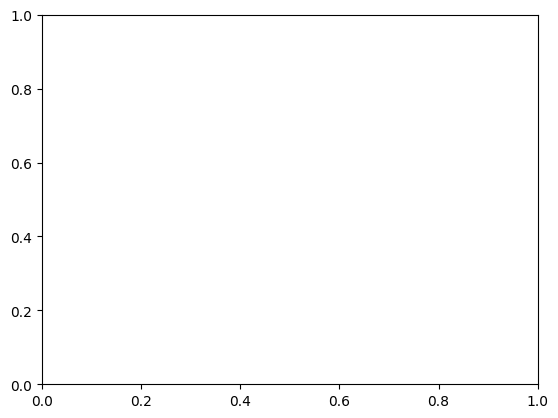

In [16]:
loss_acc_plot(history)

In [ ]:
# Use GAN to create numbers
trained_gen = cond_gan.generator

interpolation_noise = keras.random.normal(shape=(1, latent_dim))
label = keras.utils.to_categorical([3], num_classes)
label = ops.cast(label, "float32")

noise_and_labels = ops.concatenate([interpolation_noise, label], 1)

fake = trained_gen.predict(noise_and_labels)

fake *= 255.0
converted_images = fake.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("generator trial.png", converted_images[:, :, :, 0])
embed.embed_file("generator trial.png")

## 5. Interpolation between classes using the trained generator



In [17]:
# Extract the generator from our Conditional GAN
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated between the interpolation + 2 (initial and final images)
num_interpolation = 9  

# Random noise for the interpolation
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # One-Hot encode initial and end labels
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate interpolation vector between labels
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine noise and labels and execute generator
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 2  # First interpolation class
end_class = 7  # Last interpolation class

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step



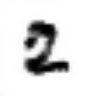

In [18]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")

In these steps, we've generated a GAN network with a generator and a discriminator that have learned to generate (and detect) handwritten numbers.

The underlying idea behind these networks is to adjust the weights of the generator to convert a random vector into an image that is similar to the probability distribution of the images. The discriminator is used as part of the structure that allows the generator to learn, through its weights, to "imitate" the probability distribution.

We've created a generator and a discriminator based on Conv2DTranspose layers (for the generator) and Conv2D layers (for the discriminator). The idea of using Conv2DTranspose layers in the generator is simply that we need to adjust the dimensions of the input vector to those of the image that can serve as input to the discriminator, while in the discriminator we reduce that image to a smaller output.

In terms of training, we see how near the beginning we have a peak of loss in the generator, which runs parallel to a valley in the discriminator. This peak later disappears, it is possible that it has to do with the fact that the discriminator learns faster than the generator, and when the generator learns to improve its images it is able to deceive the discriminator and decrease its loss, although it is only a hypothesis. It is true that, when I have used a low value of training epochs (20), so that it ends near the end of the peak, the results when generating numbers are particularly bad, while if I let it run up to 100 epochs the results improve a lot, which could support that hypothesis.

In order to visualize the efficiency of the generator I have added a chunk of code that generates a specific number and shows the output of the generator. It seems that the result is acceptable, although perhaps it would be convenient to have a larger number of real images for training.

Finally, with respect to the interpolation between numbers, this is based again on the idea of probability distributions for the different numbers. Once our generator is trained, in principle it should be able to adequately "emulate" the outputs of the different numbers and the probability distributions that exist between them. In the interpolation, this idea is verified by having the generator return the "hybrids" between two specific numbers in a gif.